# Agent-Based Kinetics via Topology (ABa-KiTo)
Date: 24.10.2025

In this notebook I try to run the mokito method using agent-based model simulation data, 
With different Initial intervals and and seed to study algorithm sensitivity

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist
import pickle
import json
import pandas as pd
from datetime import datetime


import sys
import os
import torch as pt
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("NumPy version:", np.__version__)
print("Torch version:", pt.__version__)


NumPy version: 1.26.4
Torch version: 2.3.0+cpu


In [2]:
# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..",'..'))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.modules_mokito import *
from src.diagnose_clustering_results import *

In [3]:
#Load data formatted from ABM simulations and ISOKANN.jl 

# Create the path and ensure the directory exists for saving the data
data_path = os.path.join('data', 'processed', 'isokann', '001_results')
data_dir =  os.path.join(project_root, data_path,'')
# Read data
states_data = np.load(data_dir + '2025-10-20-data_VD_FC_3InteractingAgents_rand_init_capital.npz')
xs = states_data['xs'] #xs.shape (n_dim, n_samples)
ys = states_data['ys'] #ys-shape (n_dim, n_koop = 1, n_samples)

#Reshape data to use it for MoKiTo
X0 = xs.T #(n_samples, n_dim)
Xt = np.transpose(ys, (2, 1, 0))   # (n_samples, 1, n_dim)

# --- Log + Scale both X0 and Xt consistently ---
scaler = StandardScaler()

# X0
X0_log = np.log1p(X0)
X0_scaled = scaler.fit_transform(X0_log)   # (n_samples, n_dim)

# Xt: flatten for scaling
Xt_flat = Xt.reshape(-1, Xt.shape[2])      # (n_samples * n_koop, n_dim)
Xt_log = np.log1p(Xt_flat)
Xt_scaled = scaler.transform(Xt_log)
Xt_scaled = Xt_scaled.reshape(Xt.shape)    # (n_samples, 1, n_dim)


# # # --- Load chi function ---
chivals_path = os.path.join('data', 'processed', 'isokann', '001_results', 'chi_vals', '')
chivals_dir = os.path.join(project_root, chivals_path)
chi0 = np.load(data_dir + '/chi_vals/chi_values_rand_init_capitals.npz')

# --- Organize for MoKiTo ---
data = OrganizeData(X0_scaled, Xt_scaled, chi0)





Check shape of input data
X0.shape   =  (200000, 202)
Xt.shape   =  (200000, 1, 202)
chi0.shape =  (200000,)
  


In [4]:
# Create results directory
os.makedirs('stability_results', exist_ok=True)

# Run stability analysis
stability_results = []

for Nintervals in [3, 5, 7]:
    for seed in [42, 123, 456]:
        print(f"\n{'='*60}")
        print(f"Running: Nintervals={Nintervals}, seed={seed}")
        print(f"{'='*60}")
        
        # Run pipeline
        FCs = FindIntervals(data, Nintervals=Nintervals, 
                           clustering='kmeans', random_state=seed)
        FNs = FindNodes(data, FCs, algorithm='HDBSCAN', random_state=seed)
        
        # Calculate statistics
        chi_means = []
        cluster_sizes = []
        interval_assignments = []
        
        for node_id in range(FNs.Nnodes):
            mask = FNs.nodes == node_id
            chi_means.append(np.mean(data.chi0[mask]))
            cluster_sizes.append(np.sum(mask))
            interval_assignments.append(FNs.index_chi_node[node_id])
        
        chi_means = np.array(chi_means)
        cluster_sizes = np.array(cluster_sizes)
        interval_assignments = np.array(interval_assignments)
        
        # Classify into meta estable states (adjust thresholds based on your data)
        n_brown = np.sum(chi_means < 0.25)
        n_transition = np.sum((chi_means >= 0.25) & (chi_means < 0.55))
        n_green = np.sum(chi_means >= 0.55)
        
        # Store results
        result = {
            'Nintervals': Nintervals,
            'seed': seed,
            'n_clusters': FNs.Nnodes,
            'noise_count': np.sum(FNs.nodes == -1),
            'noise_pct': 100 * np.sum(FNs.nodes == -1) / data.N,
            'n_brown': n_brown,
            'n_transition': n_transition,
            'n_green': n_green,
            'chi_min': float(chi_means.min()),
            'chi_max': float(chi_means.max()),
            'chi_mean': float(chi_means.mean()),
            'chi_std': float(chi_means.std()),
            'clusters_per_interval': FNs.index_chi_node.tolist() if hasattr(FNs.index_chi_node, 'tolist') else list(np.bincount(FNs.index_chi_node)),
            'mean_cluster_size': float(cluster_sizes.mean()),
            'median_cluster_size': float(np.median(cluster_sizes)),
            'max_cluster_size': int(cluster_sizes.max()),
            'min_cluster_size': int(cluster_sizes.min()),
            # Detailed per-cluster info
            'chi_per_cluster': chi_means.tolist(),
            'size_per_cluster': cluster_sizes.tolist(),
            'interval_per_cluster': interval_assignments.tolist(),
        }
        
        stability_results.append(result)
        
        # Save individual run (in case of crashes)
        run_name = f"Nint{Nintervals}_seed{seed}"
        
        # Save as pickle (preserves all Python objects)
        with open(f'stability_results/{run_name}_FNs.pkl', 'wb') as f:
            pickle.dump(FNs, f)
        
        with open(f'stability_results/{run_name}_FCs.pkl', 'wb') as f:
            pickle.dump(FCs, f)
        
        print(f"\nSummary:")
        print(f"  Total clusters: {FNs.Nnodes}")
        print(f"  Noise: {result['noise_pct']:.1f}%")
        print(f"  Basins: Brown={n_brown}, Transition={n_transition}, Green={n_green}")
        print(f"  Chi range: [{result['chi_min']:.3f}, {result['chi_max']:.3f}]")

# Save all results as JSON (human-readable)
# with open('stability_results/all_results.json', 'w') as f:
#     json.dump(stability_results, f, indent=2)

# Save as DataFrame for easy analysis
df = pd.DataFrame(stability_results)
df.to_csv('stability_results/summary.csv', index=False)
print(f"\n{'='*60}")
print("All results saved to stability_results/")
print(f"{'='*60}")


Running: Nintervals=3, seed=42
Computing geometric interval densities...
unormalized density: [0.52694508 0.46646443 0.3628087 ]
Density estimates: min=0.778, median=1.000, max=1.130
d_low (25th percentile)=0.889, d_high (75th percentile)=1.065


Processing intervals:  33%|███▎      | 1/3 [51:49<1:43:39, 3109.65s/it]

Interval 0: size=131299, density=1.130, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 9677 noise (7.4%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=49. Retrying with relaxed parameters...


Processing intervals:  67%|██████▋   | 2/3 [1:11:46<33:04, 1984.33s/it]

Interval 1: size=59102, density=1.000, min_cluster=39, min_samples=5, eps=1.26, method=eom (fallback) → 2 clusters, 2795 noise (4.7%), reassigned=92.0%


Processing intervals: 100%|██████████| 3/3 [1:12:04<00:00, 1441.41s/it]

Interval 2: size=9599, density=0.778, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 2 clusters, 742 noise (7.7%), reassigned=92.0%

Summary:
  Total clusters: 6
  Noise: 6.6%
  Basins: Brown=2, Transition=2, Green=2
  Chi range: [0.152, 0.813]

Running: Nintervals=3, seed=123


Computing geometric interval densities...
unormalized density: [0.53107932 0.47568815 0.36332203]
Density estimates: min=0.764, median=1.000, max=1.116
d_low (25th percentile)=0.882, d_high (75th percentile)=1.058


Processing intervals:  33%|███▎      | 1/3 [50:00<1:40:01, 3000.99s/it]

Interval 0: size=130075, density=1.116, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 9583 noise (7.4%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=50. Retrying with relaxed parameters...


Processing intervals:  67%|██████▋   | 2/3 [1:10:57<32:54, 1974.67s/it]

Interval 1: size=60205, density=1.000, min_cluster=40, min_samples=6, eps=1.26, method=eom (fallback) → 0 clusters, 60205 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 3/3 [1:11:15<00:00, 1425.16s/it]

Interval 2: size=9720, density=0.764, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 2 clusters, 749 noise (7.7%), reassigned=92.0%

Summary:
  Total clusters: 4
  Noise: 35.3%
  Basins: Brown=2, Transition=0, Green=2
  Chi range: [0.151, 0.812]

Running: Nintervals=3, seed=456


Computing geometric interval densities...
unormalized density: [0.53382368 0.47308534 0.36271557]
Density estimates: min=0.767, median=1.000, max=1.128
d_low (25th percentile)=0.883, d_high (75th percentile)=1.064


Processing intervals:  33%|███▎      | 1/3 [50:33<1:41:06, 3033.12s/it]

Interval 0: size=131176, density=1.128, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 9667 noise (7.4%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=49. Retrying with relaxed parameters...


Processing intervals:  67%|██████▋   | 2/3 [1:10:30<32:33, 1953.26s/it]

Interval 1: size=59219, density=1.000, min_cluster=39, min_samples=5, eps=1.26, method=eom (fallback) → 2 clusters, 2799 noise (4.7%), reassigned=92.0%


Processing intervals: 100%|██████████| 3/3 [1:10:48<00:00, 1416.12s/it]

Interval 2: size=9605, density=0.767, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 2 clusters, 742 noise (7.7%), reassigned=92.0%

Summary:
  Total clusters: 6
  Noise: 6.6%
  Basins: Brown=2, Transition=2, Green=2
  Chi range: [0.152, 0.813]

Running: Nintervals=5, seed=42


Computing geometric interval densities...
unormalized density: [0.55283573 0.4835415  0.47050888 0.36363401 0.3481631 ]
Density estimates: min=0.740, median=1.000, max=1.175
d_low (25th percentile)=0.773, d_high (75th percentile)=1.028


Processing intervals:  20%|██        | 1/5 [18:48<1:15:14, 1128.60s/it]

Interval 0: size=78522, density=1.175, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 5678 noise (7.2%), reassigned=92.0%


Processing intervals:  40%|████      | 2/5 [32:03<46:37, 932.35s/it]   

Interval 1: size=67550, density=1.028, min_cluster=51, min_samples=8, eps=1.02, method=eom → 2 clusters, 5235 noise (7.7%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=45. Retrying with relaxed parameters...


Processing intervals:  60%|██████    | 3/5 [39:58<24:06, 723.28s/it]

Interval 2: size=36559, density=1.000, min_cluster=36, min_samples=5, eps=1.26, method=eom (fallback) → 13 clusters, 1792 noise (4.9%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  80%|████████  | 4/5 [40:40<07:34, 454.55s/it]

Interval 3: size=10738, density=0.773, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 10738 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 5/5 [40:49<00:00, 489.85s/it]

Interval 4: size=6631, density=0.740, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 4 clusters, 502 noise (7.6%), reassigned=92.0%

Summary:
  Total clusters: 21
  Noise: 12.0%
  Basins: Brown=4, Transition=13, Green=4
  Chi range: [0.120, 0.863]

Running: Nintervals=5, seed=123


Computing geometric interval densities...
unormalized density: [0.54897027 0.48576016 0.47129155 0.37122291 0.3480095 ]
Density estimates: min=0.738, median=1.000, max=1.165
d_low (25th percentile)=0.788, d_high (75th percentile)=1.031


Processing intervals:  20%|██        | 1/5 [18:31<1:14:07, 1111.86s/it]

Interval 0: size=77998, density=1.165, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 5638 noise (7.2%), reassigned=92.0%


Processing intervals:  40%|████      | 2/5 [31:51<46:25, 928.46s/it]   

Interval 1: size=67748, density=1.031, min_cluster=51, min_samples=8, eps=1.02, method=eom → 2 clusters, 5249 noise (7.7%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=45. Retrying with relaxed parameters...


Processing intervals:  60%|██████    | 3/5 [39:54<24:09, 724.89s/it]

Interval 2: size=36833, density=1.000, min_cluster=36, min_samples=5, eps=1.26, method=eom (fallback) → 12 clusters, 1800 noise (4.9%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  80%|████████  | 4/5 [40:37<07:35, 455.61s/it]

Interval 3: size=10782, density=0.788, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 10782 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 5/5 [40:46<00:00, 489.21s/it]

Interval 4: size=6639, density=0.738, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 4 clusters, 502 noise (7.6%), reassigned=92.0%

Summary:
  Total clusters: 20
  Noise: 12.0%
  Basins: Brown=4, Transition=12, Green=4
  Chi range: [0.120, 0.862]

Running: Nintervals=5, seed=456


Computing geometric interval densities...
unormalized density: [0.55182865 0.48416428 0.4715291  0.36875502 0.34864738]
Density estimates: min=0.739, median=1.000, max=1.170
d_low (25th percentile)=0.782, d_high (75th percentile)=1.027


Processing intervals:  20%|██        | 1/5 [18:51<1:15:24, 1131.01s/it]

Interval 0: size=78583, density=1.170, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 5683 noise (7.2%), reassigned=92.0%


Processing intervals:  40%|████      | 2/5 [31:53<46:17, 925.78s/it]   

Interval 1: size=67021, density=1.027, min_cluster=51, min_samples=8, eps=1.02, method=eom → 2 clusters, 5193 noise (7.7%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=45. Retrying with relaxed parameters...


Processing intervals:  60%|██████    | 3/5 [39:48<23:59, 719.96s/it]

Interval 2: size=36590, density=1.000, min_cluster=36, min_samples=5, eps=1.26, method=eom (fallback) → 11 clusters, 1791 noise (4.9%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  80%|████████  | 4/5 [40:33<07:33, 453.68s/it]

Interval 3: size=11093, density=0.782, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 11093 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 5/5 [40:42<00:00, 488.50s/it]

Interval 4: size=6713, density=0.739, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 3 clusters, 482 noise (7.2%), reassigned=92.0%

Summary:
  Total clusters: 18
  Noise: 12.1%
  Basins: Brown=4, Transition=11, Green=3
  Chi range: [0.120, 0.865]

Running: Nintervals=7, seed=42


Computing geometric interval densities...
unormalized density: [0.58050003 0.48657832 0.48112611 0.45826991 0.41219672 0.27886074
 0.34611951]
Density estimates: min=0.609, median=1.000, max=1.267
d_low (25th percentile)=0.827, d_high (75th percentile)=1.056


Processing intervals:  14%|█▍        | 1/7 [06:12<37:15, 372.63s/it]

Interval 0: size=46143, density=1.267, min_cluster=42, min_samples=6, eps=1.00, method=eom → 2 clusters, 3184 noise (6.9%), reassigned=92.0%


Processing intervals:  29%|██▊       | 2/7 [15:22<39:44, 476.83s/it]

Interval 1: size=56022, density=1.062, min_cluster=45, min_samples=7, eps=1.00, method=eom → 2 clusters, 4185 noise (7.5%), reassigned=92.0%


Processing intervals:  43%|████▎     | 3/7 [20:38<26:53, 403.46s/it]

Interval 2: size=43959, density=1.050, min_cluster=42, min_samples=6, eps=1.00, method=eom → 2 clusters, 3429 noise (7.8%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=45. Retrying with relaxed parameters...


Processing intervals:  57%|█████▋    | 4/7 [25:34<18:03, 361.09s/it]

Interval 3: size=28947, density=1.000, min_cluster=36, min_samples=5, eps=1.26, method=leaf (fallback) → 8 clusters, 1456 noise (5.0%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  71%|███████▏  | 5/7 [26:47<08:34, 257.12s/it]

Interval 4: size=14018, density=0.899, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 4 clusters, 915 noise (6.5%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  86%|████████▌ | 6/7 [26:58<02:53, 173.43s/it]

Interval 5: size=5302, density=0.609, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 5302 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 7/7 [27:04<00:00, 232.09s/it]

Interval 6: size=5609, density=0.755, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 2 clusters, 431 noise (7.7%), reassigned=92.0%

Summary:
  Total clusters: 20
  Noise: 9.5%
  Basins: Brown=6, Transition=12, Green=2
  Chi range: [0.098, 0.880]

Running: Nintervals=7, seed=123


Computing geometric interval densities...
unormalized density: [0.57388676 0.47982874 0.47398165 0.45366885 0.39560751 0.24888535
 0.34547822]
Density estimates: min=0.549, median=1.000, max=1.265
d_low (25th percentile)=0.817, d_high (75th percentile)=1.051


Processing intervals:  14%|█▍        | 1/7 [07:21<44:09, 441.65s/it]

Interval 0: size=49889, density=1.265, min_cluster=43, min_samples=6, eps=1.00, method=eom → 2 clusters, 3455 noise (6.9%), reassigned=92.0%


Processing intervals:  29%|██▊       | 2/7 [17:02<43:37, 523.41s/it]

Interval 1: size=57555, density=1.058, min_cluster=46, min_samples=7, eps=1.00, method=eom → 2 clusters, 4310 noise (7.5%), reassigned=92.0%


Processing intervals:  43%|████▎     | 3/7 [22:22<28:43, 430.75s/it]

Interval 2: size=43598, density=1.045, min_cluster=43, min_samples=6, eps=1.01, method=eom → 2 clusters, 1147 noise (2.6%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=45. Retrying with relaxed parameters...


Processing intervals:  57%|█████▋    | 4/7 [26:38<18:05, 361.71s/it]

Interval 3: size=26946, density=1.000, min_cluster=36, min_samples=5, eps=1.26, method=leaf (fallback) → 7 clusters, 1420 noise (5.3%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  71%|███████▏  | 5/7 [27:29<08:19, 249.76s/it]

Interval 4: size=11886, density=0.872, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 11886 noise (100.0%), reassigned=0.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  86%|████████▌ | 6/7 [27:38<02:47, 167.81s/it]

Interval 5: size=4720, density=0.549, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 4720 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 7/7 [27:44<00:00, 237.77s/it]

Interval 6: size=5406, density=0.762, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 3 clusters, 411 noise (7.6%), reassigned=92.0%

Summary:
  Total clusters: 16
  Noise: 13.7%
  Basins: Brown=6, Transition=7, Green=3
  Chi range: [0.100, 0.884]

Running: Nintervals=7, seed=456


Computing geometric interval densities...
unormalized density: [0.5715237  0.48527071 0.48206819 0.45880602 0.39269034 0.25200954
 0.34572652]
Density estimates: min=0.549, median=1.000, max=1.246
d_low (25th percentile)=0.805, d_high (75th percentile)=1.054


Processing intervals:  14%|█▍        | 1/7 [07:35<45:34, 455.80s/it]

Interval 0: size=50639, density=1.246, min_cluster=43, min_samples=6, eps=1.00, method=eom → 2 clusters, 3510 noise (6.9%), reassigned=92.0%


Processing intervals:  29%|██▊       | 2/7 [17:17<44:09, 529.80s/it]

Interval 1: size=57609, density=1.058, min_cluster=46, min_samples=7, eps=1.00, method=eom → 2 clusters, 4315 noise (7.5%), reassigned=92.0%


Processing intervals:  43%|████▎     | 3/7 [22:15<28:16, 424.03s/it]

Interval 2: size=42866, density=1.051, min_cluster=42, min_samples=6, eps=1.00, method=eom → 2 clusters, 3359 noise (7.8%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=45. Retrying with relaxed parameters...


Processing intervals:  57%|█████▋    | 4/7 [26:20<17:39, 353.16s/it]

Interval 3: size=26355, density=1.000, min_cluster=36, min_samples=5, eps=1.26, method=leaf (fallback) → 7 clusters, 1396 noise (5.3%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  71%|███████▏  | 5/7 [27:13<08:09, 244.90s/it]

Interval 4: size=12104, density=0.856, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 12104 noise (100.0%), reassigned=0.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  86%|████████▌ | 6/7 [27:22<02:44, 164.84s/it]

Interval 5: size=4916, density=0.549, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 0 clusters, 4916 noise (100.0%), reassigned=0.0%


Processing intervals: 100%|██████████| 7/7 [27:28<00:00, 235.50s/it]

Interval 6: size=5511, density=0.754, min_cluster=47, min_samples=7, eps=1.10, method=leaf → 3 clusters, 419 noise (7.6%), reassigned=92.0%

Summary:
  Total clusters: 16
  Noise: 15.0%
  Basins: Brown=6, Transition=7, Green=3
  Chi range: [0.101, 0.882]

All results saved to stability_results/



=== STABILITY ANALYSIS SUMMARY ===

Overall Statistics:
  Total runs: 9
  Clusters per run: 14.1 ± 6.8
  Noise percentage: 13.6% ± 8.6%

Basin Structure (average across runs):
  Brown clusters: 4.0 ± 1.7
  Transition clusters: 7.3 ± 5.0
  Green clusters: 2.8 ± 0.8

Chi Value Ranges:
  Min chi: 0.124 ± 0.023
  Max chi: 0.853 ± 0.031


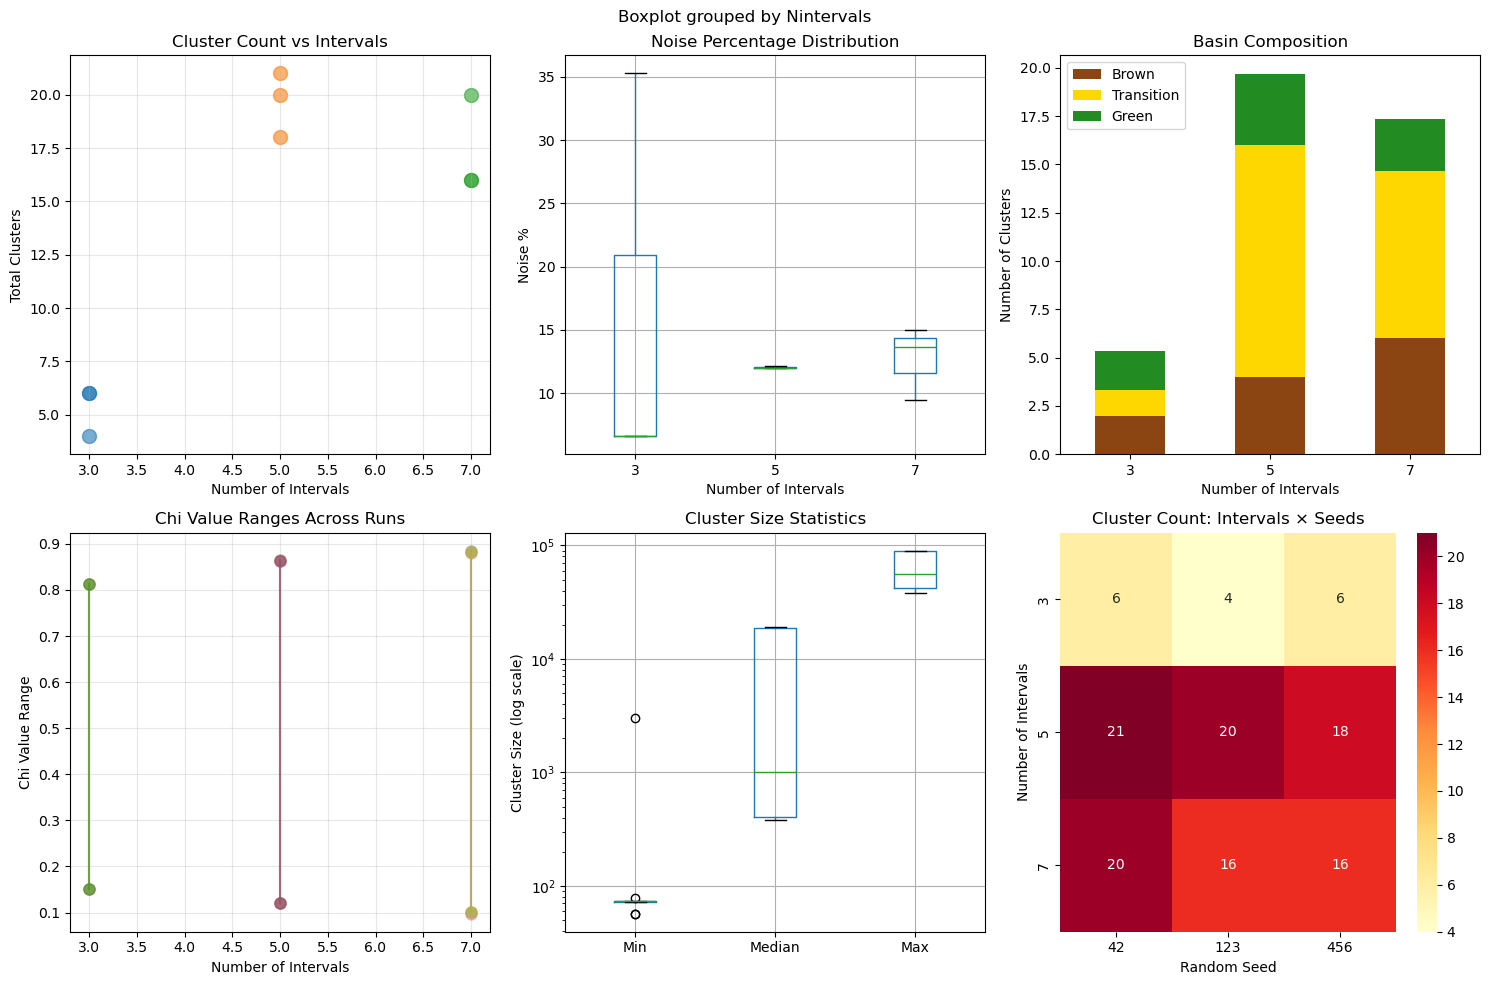


Figure saved to stability_results/stability_analysis.png


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
df = pd.read_csv('stability_results/summary.csv')

# Create summary statistics
print("\n=== STABILITY ANALYSIS SUMMARY ===\n")
print("Overall Statistics:")
print(f"  Total runs: {len(df)}")
print(f"  Clusters per run: {df['n_clusters'].mean():.1f} ± {df['n_clusters'].std():.1f}")
print(f"  Noise percentage: {df['noise_pct'].mean():.1f}% ± {df['noise_pct'].std():.1f}%")
print(f"\nBasin Structure (average across runs):")
print(f"  Brown clusters: {df['n_brown'].mean():.1f} ± {df['n_brown'].std():.1f}")
print(f"  Transition clusters: {df['n_transition'].mean():.1f} ± {df['n_transition'].std():.1f}")
print(f"  Green clusters: {df['n_green'].mean():.1f} ± {df['n_green'].std():.1f}")
print(f"\nChi Value Ranges:")
print(f"  Min chi: {df['chi_min'].mean():.3f} ± {df['chi_min'].std():.3f}")
print(f"  Max chi: {df['chi_max'].mean():.3f} ± {df['chi_max'].std():.3f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Number of clusters vs parameters
ax = axes[0, 0]
for Nint in [3, 5, 7]:
    subset = df[df['Nintervals'] == Nint]
    ax.scatter([Nint]*len(subset), subset['n_clusters'], 
               s=100, alpha=0.6, label=f'N={Nint}')
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Total Clusters')
ax.set_title('Cluster Count vs Intervals')
ax.grid(True, alpha=0.3)

# 2. Noise percentage
ax = axes[0, 1]
df.boxplot(column='noise_pct', by='Nintervals', ax=ax)
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Noise %')
ax.set_title('Noise Percentage Distribution')
plt.sca(ax)
plt.xticks([1, 2, 3], [3, 5, 7])

# 3. Basin composition
ax = axes[0, 2]
basin_means = df.groupby('Nintervals')[['n_brown', 'n_transition', 'n_green']].mean()
basin_means.plot(kind='bar', stacked=True, ax=ax, 
                 color=['#8B4513', '#FFD700', '#228B22'])
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Number of Clusters')
ax.set_title('Basin Composition')
ax.legend(['Brown', 'Transition', 'Green'])
ax.set_xticklabels([3, 5, 7], rotation=0)

# 4. Chi range stability
ax = axes[1, 0]
for idx, row in df.iterrows():
    ax.plot([row['Nintervals']]*2, [row['chi_min'], row['chi_max']], 
            'o-', alpha=0.5, markersize=8)
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Chi Value Range')
ax.set_title('Chi Value Ranges Across Runs')
ax.grid(True, alpha=0.3)

# 5. Cluster size distribution
ax = axes[1, 1]
df.boxplot(column=['min_cluster_size', 'median_cluster_size', 'max_cluster_size'], 
           ax=ax)
ax.set_ylabel('Cluster Size (log scale)')
ax.set_yscale('log')
ax.set_title('Cluster Size Statistics')
ax.set_xticklabels(['Min', 'Median', 'Max'], rotation=0)

# 6. Reproducibility heatmap
ax = axes[1, 2]
pivot = df.pivot_table(values='n_clusters', 
                       index='Nintervals', 
                       columns='seed', 
                       aggfunc='first')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax)
ax.set_title('Cluster Count: Intervals × Seeds')
ax.set_xlabel('Random Seed')
ax.set_ylabel('Number of Intervals')

plt.tight_layout()
plt.savefig('stability_results/stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved to stability_results/stability_analysis.png")

In [7]:
# Simple stability checks
print("\n=== STABILITY CHECKS ===\n")

# Check 1: Does 3-basin structure always appear?
all_have_basins = all((df['n_brown'] > 0) & 
                      (df['n_transition'] > 0) & 
                      (df['n_green'] > 0))
print(f"✓ All runs show 3-basin structure: {all_have_basins}")

# Check 2: Are chi ranges consistent?
chi_range_cv = df['chi_min'].std() / df['chi_min'].mean()
print(f"✓ Chi minimum coefficient of variation: {chi_range_cv:.2%}")
print(f"  (< 10% = very stable, < 20% = stable, > 20% = variable)")

# Check 3: Is noise percentage reasonable?
noise_stable = df['noise_pct'].std() < 5.0  # Less than 5% variation
print(f"✓ Noise percentage stable (σ < 5%): {noise_stable}")
print(f"  Mean: {df['noise_pct'].mean():.1f}%, Std: {df['noise_pct'].std():.1f}%")

# Check 4: Does structure scale predictably with Nintervals?
corr = df[['Nintervals', 'n_clusters']].corr().iloc[0, 1]
print(f"✓ Clusters scale with intervals (correlation): {corr:.2f}")
print(f"  (> 0.8 = predictable scaling)")





=== STABILITY CHECKS ===

✓ All runs show 3-basin structure: False
✓ Chi minimum coefficient of variation: 18.32%
  (< 10% = very stable, < 20% = stable, > 20% = variable)
✓ Noise percentage stable (σ < 5%): False
  Mean: 13.6%, Std: 8.6%
✓ Clusters scale with intervals (correlation): 0.76
  (> 0.8 = predictable scaling)


In [8]:
import pandas as pd
import json

# Load results
df = pd.read_csv('stability_results/summary.csv')

print("\n=== DETAILED DIAGNOSTICS ===\n")

# Find runs missing basins
print("Runs missing basins:")
for idx, row in df.iterrows():
    missing = []
    if row['n_brown'] == 0:
        missing.append('BROWN')
    if row['n_transition'] == 0:
        missing.append('TRANSITION')
    if row['n_green'] == 0:
        missing.append('GREEN')
    
    if missing:
        print(f"  Nint={row['Nintervals']}, seed={row['seed']}: Missing {', '.join(missing)}")
        print(f"    → {row['n_clusters']} clusters, {row['noise_pct']:.1f}% noise")
        print(f"    → Chi range: [{row['chi_min']:.3f}, {row['chi_max']:.3f}]")

# Find high-noise runs
print("\nHigh noise runs (>15%):")
high_noise = df[df['noise_pct'] > 15]
for idx, row in high_noise.iterrows():
    print(f"  Nint={row['Nintervals']}, seed={row['seed']}: {row['noise_pct']:.1f}% noise")
    print(f"    → Basins: B={row['n_brown']}, T={row['n_transition']}, G={row['n_green']}")

# Show variation by Nintervals
print("\nStatistics by Nintervals:")
print(df.groupby('Nintervals')[['n_clusters', 'noise_pct', 'n_brown', 'n_transition', 'n_green']].agg(['mean', 'std']))


=== DETAILED DIAGNOSTICS ===

Runs missing basins:
  Nint=3, seed=123: Missing TRANSITION
    → 4 clusters, 35.3% noise
    → Chi range: [0.151, 0.812]

High noise runs (>15%):
  Nint=3, seed=123: 35.3% noise
    → Basins: B=2, T=0, G=2
  Nint=7, seed=456: 15.0% noise
    → Basins: B=6, T=7, G=3

Statistics by Nintervals:
           n_clusters            noise_pct            n_brown       \
                 mean       std       mean        std    mean  std   
Nintervals                                                           
3            5.333333  1.154701  16.159833  16.548591     2.0  0.0   
5           19.666667  1.527525  12.026333   0.082241     4.0  0.0   
7           17.333333  2.309401  12.711667   2.901640     6.0  0.0   

           n_transition             n_green           
                   mean       std      mean      std  
Nintervals                                            
3              1.333333  1.154701  2.000000  0.00000  
5             12.000000  1.000000 

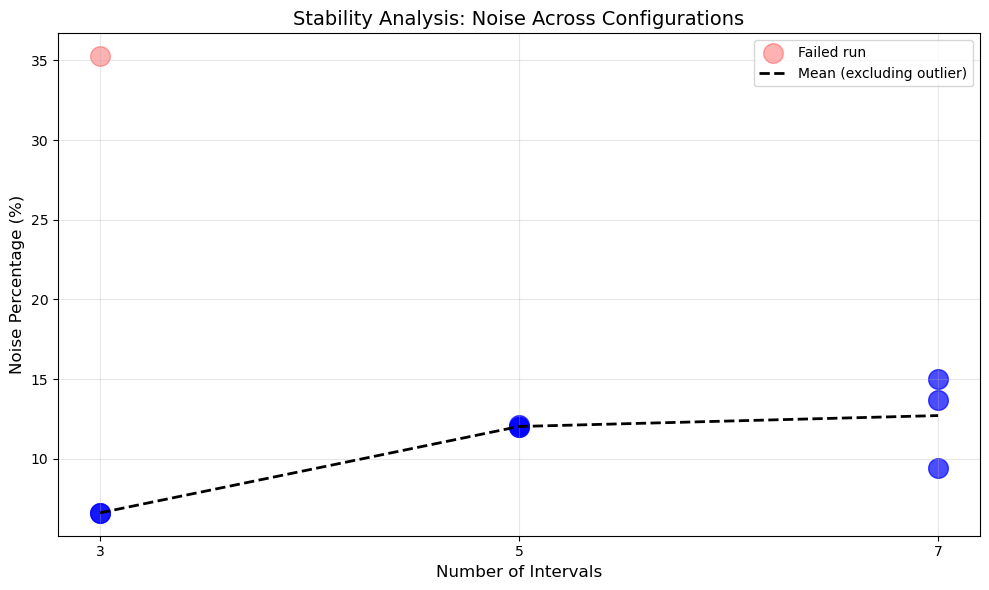

In [9]:
# Add annotation to your stability plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all runs
for idx, row in df.iterrows():
    color = 'red' if (row['Nintervals']==3 and row['seed']==123) else 'blue'
    alpha = 0.3 if (row['Nintervals']==3 and row['seed']==123) else 0.7
    label = 'Failed run' if (row['Nintervals']==3 and row['seed']==123 and idx==1) else ''
    
    ax.scatter(row['Nintervals'], row['noise_pct'], 
              s=200, alpha=alpha, color=color, label=label)

# Add means for each Nintervals
df_clean = df[~((df['Nintervals'] == 3) & (df['seed'] == 123))]
means = df_clean.groupby('Nintervals')['noise_pct'].mean()
ax.plot(means.index, means.values, 'k--', linewidth=2, label='Mean (excluding outlier)')

ax.set_xlabel('Number of Intervals', fontsize=12)
ax.set_ylabel('Noise Percentage (%)', fontsize=12)
ax.set_title('Stability Analysis: Noise Across Configurations', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks([3, 5, 7])

plt.tight_layout()
plt.savefig('stability_results/noise_stability.png', dpi=300)
plt.show()